Celem zadania jest obserwacja wpływu kompresji Condensed Nearest Neighbours, w skrócie CNN.

In [3]:
!pip install webcolors

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import webcolors
from PIL import Image
from sklearn.neighbors import KNeighborsClassifier
from imblearn.under_sampling import CondensedNearestNeighbour
from matplotlib.colors import ListedColormap
from pandas.core.frame import DataFrame
from typing import Dict, Tuple

Ponizszy kod do normalizacji danych, przeniesienia go do formatu csv, dodaniu szumu jest identyczny z poprzednim zadaniem.

Skorzystalem z tych samych danych co do zadania z KNN.

In [0]:
colors_dict = {
    '#ffffff': ('white', 0),
    '#ff0000': ('red', 1),
    '#ffbf00': ('orange', 2),
    '#ffff00': ('yellow', 3),
    '#00ff00': ('green', 4),
    '#00bfff': ('blue', 5),
    '#0000ff': ('dark blue', 6),
    '#551a8b': ('purple', 7),
    '#ffb6c1': ('pink', 8),
    '#000000': ('black', 9)
}

def closest_colour(requested_colour):
    min_colours = {}
    for key, name in colors_dict.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    return min_colours[min(min_colours.keys())]

def get_colour_name(requested_colour):
    try:
        closest_name = webcolors.rgb_to_name(requested_colour)
    except ValueError:
        closest_name = closest_colour(requested_colour)
    return closest_name

def noise(point: float):
    return point + random.gauss(0, 1)

def write_data_to_csv(source_img: str, dest_path: str):
    """
    Save given image to csv-like format.
    Csv file contains 4 columns: x co-ordinate, y co-ordinate, color number, color name
    """
    image = Image.open(source_img)
    width, height = image.size
    with open(dest_path, 'w') as dest_file:
        for x in range(0, width):
            for y in range(0, height):
                color, color_num = closest_colour(image.getpixel((x,y)))
                if color != 'white':
                    dest_file.write(f'{noise(x)};{noise(y)};{color_num};{color}\n')
                  


In [0]:
data = ('data7.png', 'data8.png', 'data9.png')
output_paths = ('labeled-dataset1.csv', 'labeled-dataset2.csv','labeled-dataset3.csv')

%matplotlib inline
def show_data(img_path):
    pil_im = Image.open(img_path, 'r')
    plt.imshow(np.asarray(pil_im))

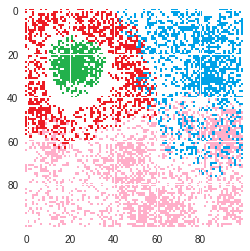

In [7]:
show_data(data[0])

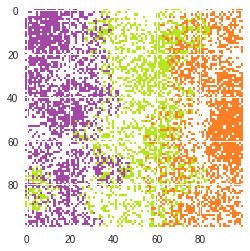

In [8]:
show_data(data[1])

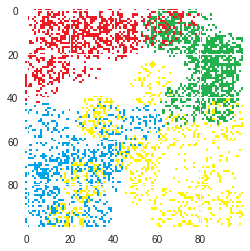

In [9]:
show_data(data[2])

Kod do trenowania, fitowania i wizualizacji w duzej mierze tez jest taki sam. Biblioteka imblearn zapewnia gotowa implementacje under samplingu oparta o algorytm CNN, dzieki czemu oszczedzilem wiele czasu. Obiektowi CondensedNearestNeighbour wystarczy tylko nalozyc dane na ktorych chcemy wykonac redukcje i powiedziec mu ilu klas danych sie spodziewamy.

In [0]:
def divide_dataset(shuffled_dataset: DataFrame) -> Tuple[np.ndarray]:
  """
  Return 4-elements tuple with X_train, y_train, X_test, y_test
  Function cast input - pandas DataFrame to  to numpy array, just for calucaltion simiplicity
  """
    if shuffled_dataset.shape[1] != 3:
        raise ValueError("Shuffled dataset must contains x,y and numeric value columns")

    shuffled_dataset = np.array(shuffled_dataset)
    train_size = int(0.7 * shuffled_dataset.shape[0])
    train, test = shuffled_dataset[:train_size, :], shuffled_dataset[train_size:, :]

    return train[:, 0:2], train[:, 2], test[:, 0:2], test[:, 2]

def train(X_train: np.ndarray, 
          y_train: np.ndarray,
          k: int, 
          weights: str = 'uniform',
          metric: str = 'euclidean',
          with_cnn: bool = False,
          sampling_strat: str = 'all',
          **kwargs) -> KNeighborsClassifier:
  
    if with_cnn:
        cnn = CondensedNearestNeighbour(n_neighbors=k, sampling_strategy=sampling_strat)
        X_train, y_train = cnn.fit_resample(X_train, y_train)

    clf = KNeighborsClassifier(k, weights=weights, metric=metric, **kwargs)
    clf.fit(X_train, y_train)
    return clf


def predict(knn_classifier: KNeighborsClassifier, 
            X_train: np.ndarray, 
            y_train: np.ndarray,
            X_test: np.ndarray, 
            y_test: np.ndarray,
            h: float = 0.1) -> tuple:
  
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                           np.arange(y_min, y_max, h))

    P_train = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    P_train = P_train.reshape(xx.shape)

    accuracy = clf.score(X_test, y_test)

    return xx, yy, P_train, accuracy

def plot_decision_boundry(xx, 
                          yy, 
                          P_train,
                          X_test, 
                          y_test, 
                          cmap_light,
                          cmap_bold) -> None:
    plt.figure()
    plt.pcolormesh(xx, yy, P_train, cmap=cmap_light)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold, edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
  
def load_datasets(dataset_paths: list):
    for path in dataset_paths:
        dataset_df = pd.read_csv(path, sep=';', names=['x', 'y', 'color_name', 'color_num'])
        dataset_df = dataset_df.sample(frac=1).iloc[:, :3]
        yield dataset_df

In [0]:
cmap_light = ListedColormap(['#D7BDE2','#F9E79F', '#AED6F1', '#E6B0AA', '#A2D9CE', '#D5DBDB'])
cmap_bold = ListedColormap([ '#9B59B6','#F1C40F', '#5DADE2', '#C0392B', '#16A085', '#95A5A6'])

### kNN with k=1, uniform weights and Euclidean metric

Accuracy:  0.8955223880597015


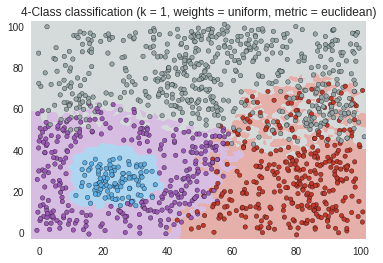

Accuracy:  0.8385382059800665


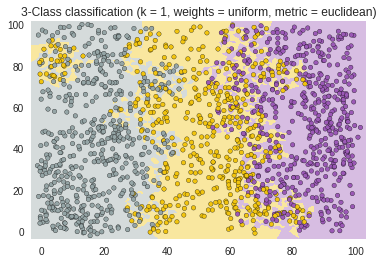

Accuracy:  0.872946330777656


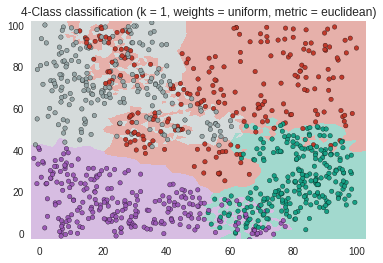

In [16]:
k = 1
weights = 'uniform'
metric = 'euclidean'


for dataset in load_datasets(output_paths):
    X_train, y_train, X_test, y_test = divide_dataset(dataset)

    clf = train(X_train, y_train, k, weights=weights)
    xx, yy, P_train, accuracy = predict(clf, X_train, y_train, X_test, y_test)
    print("Accuracy: ", accuracy)


    plot_decision_boundry(xx, yy, P_train, X_test, y_test, cmap_light, cmap_bold)

    plt.title("{}-Class classification (k = {}, weights = {}, metric = {})".format(len(np.unique(y_train)), k, weights, metric))
    plt.show()

### CNN with k=1, uniform weights and Euclidean metric (randomly selecting samples in the condensation procedure)

Accuracy:  0.6912804399057345


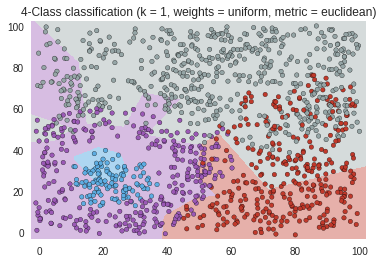

Accuracy:  0.5588039867109634


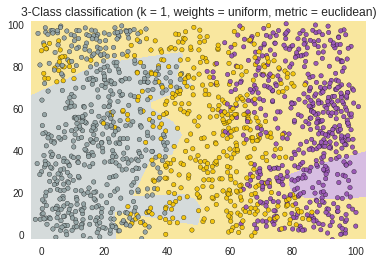

Accuracy:  0.7119386637458927


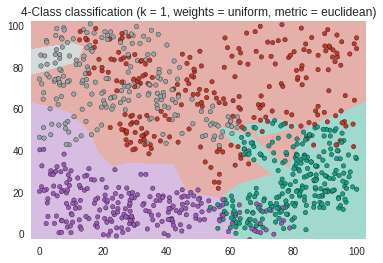

In [17]:
k = 1
weights = 'uniform'
metric = 'euclidean'


for dataset in load_datasets(output_paths):
    X_train, y_train, X_test, y_test = divide_dataset(dataset)

    clf = train(X_train, y_train, k, weights=weights, with_cnn=True)
    xx, yy, P_train, accuracy = predict(clf, X_train, y_train, X_test, y_test)
    print("Accuracy: ", accuracy)


    plot_decision_boundry(xx, yy, P_train, X_test, y_test, cmap_light, cmap_bold)

    plt.title("{}-Class classification (k = {}, weights = {}, metric = {})".format(len(np.unique(y_train)), k, weights, metric))
    plt.show()

### CNN with k=1, uniform weights and Euclidean metric (taking samples based on thier border ratio)

In [0]:
def sad_face():
    raise NotImplementedError(":<<<<")

### kNN with k=3, uniform weights and Euclidean metric

Accuracy:  0.9025923016496465


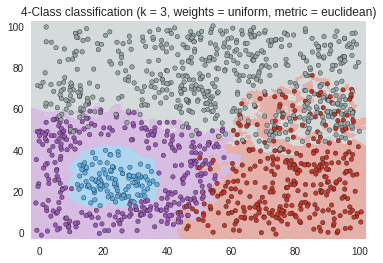

Accuracy:  0.8498338870431894


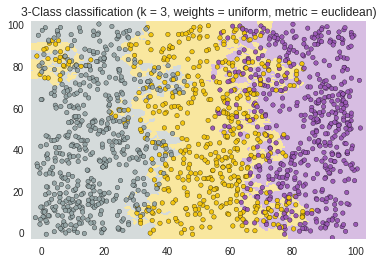

Accuracy:  0.8587075575027382


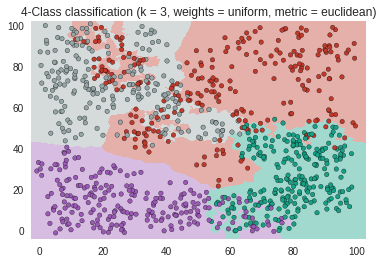

In [20]:
k = 3
weights = 'uniform'
metric = 'euclidean'


for dataset in load_datasets(output_paths):
    X_train, y_train, X_test, y_test = divide_dataset(dataset)

    clf = train(X_train, y_train, k, weights=weights)
    xx, yy, P_train, accuracy = predict(clf, X_train, y_train, X_test, y_test)
    print("Accuracy: ", accuracy)


    plot_decision_boundry(xx, yy, P_train, X_test, y_test, cmap_light, cmap_bold)

    plt.title("{}-Class classification (k = {}, weights = {}, metric = {})".format(len(np.unique(y_train)), k, weights, metric))
    plt.show()

### CNN with k=3, uniform weights and Euklidesa metric

Accuracy:  0.7659073055773763


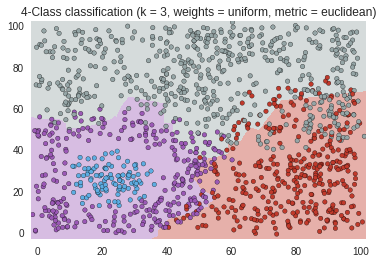

Accuracy:  0.6697674418604651


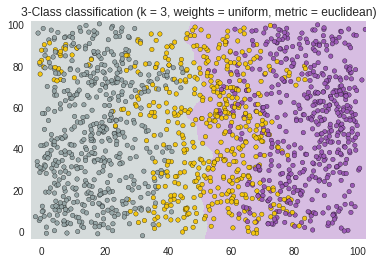

Accuracy:  0.6363636363636364


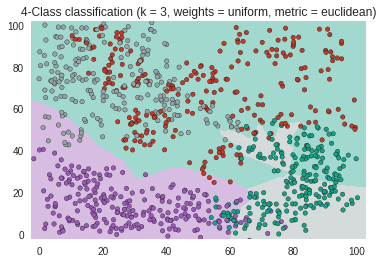

In [23]:
k = 3
weights = 'uniform'
metric = 'euclidean'


for dataset in load_datasets(output_paths):
    X_train, y_train, X_test, y_test = divide_dataset(dataset)

    clf = train(X_train, y_train, k, weights=weights, with_cnn=True)
    xx, yy, P_train, accuracy = predict(clf, X_train, y_train, X_test, y_test)
    print("Accuracy: ", accuracy)


    plot_decision_boundry(xx, yy, P_train, X_test, y_test, cmap_light, cmap_bold)

    plt.title("{}-Class classification (k = {}, weights = {}, metric = {})".format(len(np.unique(y_train)), k, weights, metric))
    plt.show()

### Wnioski:
* Uzycie CNN na moich danych okazauje sie fatalnym pomyslem. CNN redukuje zbior treningowych do tego stopnia, ze dla k=3 mniejsze klasy danych nie sa brane w ogole pod uwage. CNN przydaje sie zapewne w przypadkach gdy klasy danych nie zachodza na siebie za bardzo.
* CNN z k=3 radzi sobie delikatnie lepiej niz z k=1, lecz ani troche nie dorownuja czystemu KNN.